In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm

import scipy
from scipy.special import expit as sigmoid
import jax.numpy as jnp
import jax
import numpy as np
import numpy.typing as npt
Float = np.float64

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml
dev = qml.device("lightning.qubit", wires=18)

[cuda(id=0)]


In [2]:
dev

<lightning.qubit device (wires=18) at 0x7f28b00ebd90>

In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [5]:
dev = qml.device('lightning.gpu', wires = 18)
circuit = circuit_with_dev(circuit_angle_qft_swap, dev)

In [158]:
def rescale(x):
    #return sigmoid(x / np.linalg.norm(x, ord=1)) * np.pi/2
    return x / np.linalg.norm(x, ord=1) * np.pi/2

def get_fidelity_call(data1:list[int], data2:list[int], circuit) -> tuple[Float,Float]:
    probs = circuit(data1, data2)
    _, fidelity = swap_expectation(probs, len(data1))
    # mean = np.mean(np.array(probs)) # circuit exp value?
    return fidelity, probs

def get_fidelity(data1:list[int], data2:list[int], circuit=circuit) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1)
    # normalize data
    data1 = rescale(data1)
    data2 = rescale(data2)
    # print(data1 == data2)
    return get_fidelity_call(data1, data2, circuit)

In [159]:
# should get 1
a = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
b = np.array([2,2,2, 2,2,2, 2,2,2,], dtype=Float)
c = np.array([3]*9, dtype=Float)
#normalization will make these equal to each other

Drawing
(<Figure size 1600x1900 with 1 Axes>, <Axes: >)


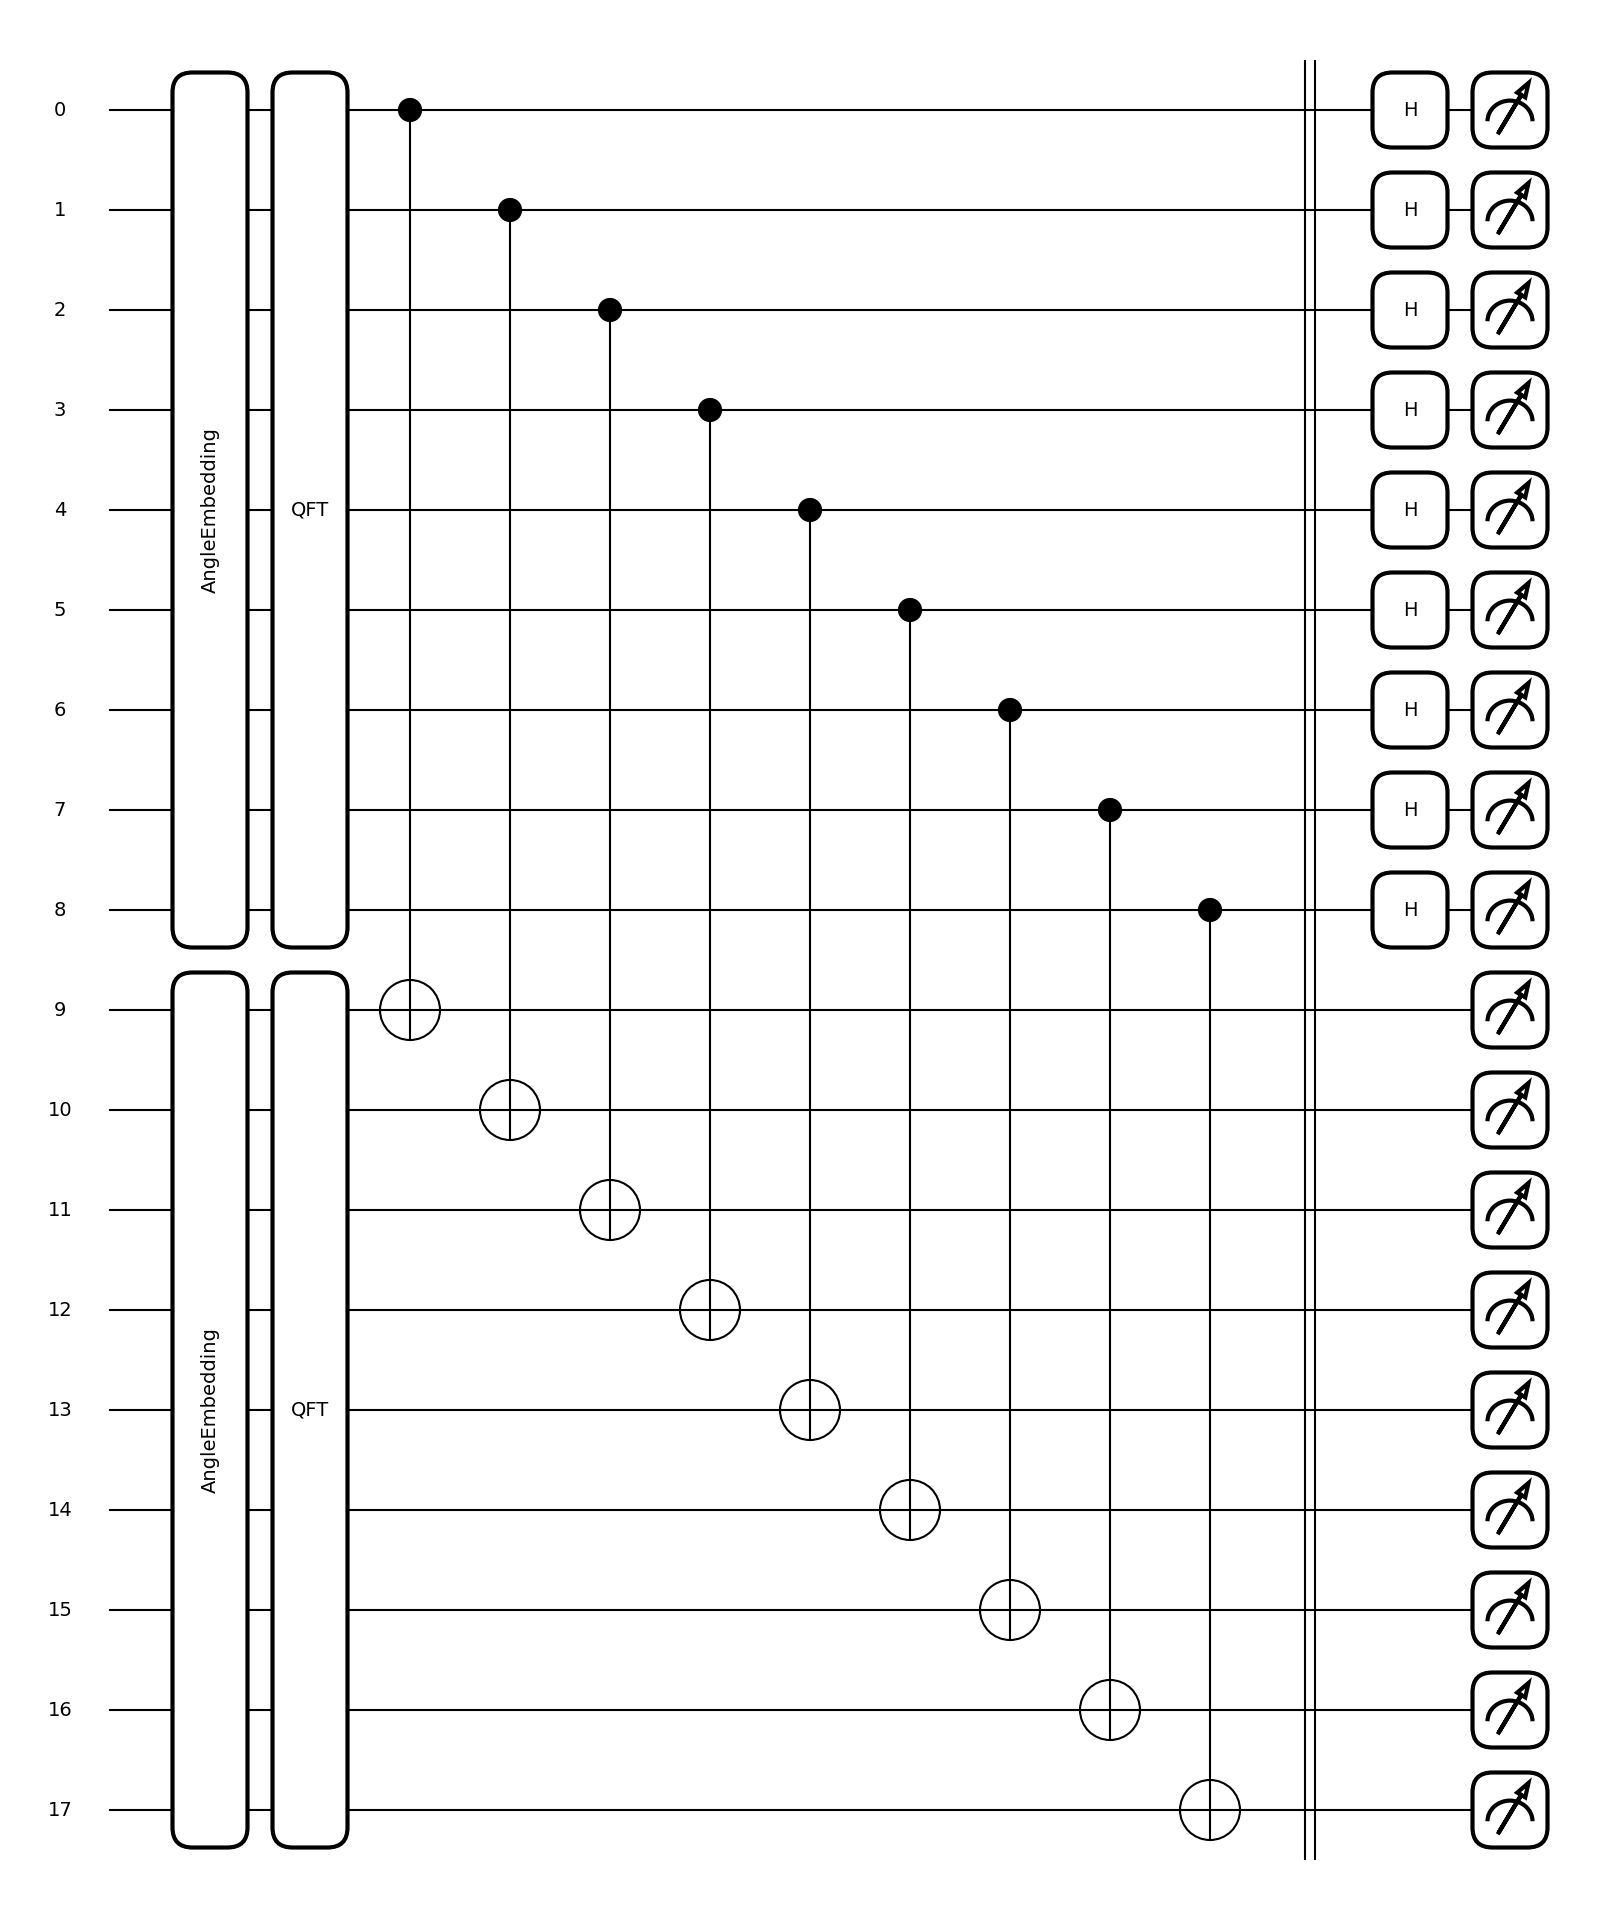

In [161]:
print('Drawing')
print(qml.draw_mpl(circuit)(rescale(a), rescale(c)))

In [154]:
fidelity, probs = get_fidelity(a, b)
fidelity

Array(1., dtype=float64)

# run simulated results on significant neurons of smallest recording

In [148]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

In [155]:
quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'mean_value', 'fidelity', 'probs'])

# A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in tqdm(pairs, total=pairs_len):
    a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
    fidelity, probs = get_fidelity(a_i, b_i)
    mean_value = np.mean(probs)
    quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, mean_value, fidelity, probs]
    quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, mean_value, fidelity, probs]

# A x A
# for sanity checking
for a in tqdm(sig_neurons):
    a_i = tuning_curves.loc[a]
    fidelity, probs = get_fidelity(a_i, a_i)
    mean_value = np.mean(probs)
    quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, mean_value, fidelity, probs]

quantum_fidelity.to_csv(ROOT + '/data/quantum_fidelity.csv')

  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [18]:
quantum_fidelity_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['fidelity']

In [19]:
quantum_mean_matrix = quantum_fidelity.pivot_table(index = 'A', columns = 'B')['mean_value']

In [50]:
quantum_fidelity_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
B,,,,,,,,,,,,,,,,,,,,,
23,1.000000,0.710348,0.980893,0.878280,0.960934,0.989494,0.980937,0.994598,0.986062,0.945612,...,0.962201,0.925019,0.920279,0.864807,0.875617,0.846837,0.985184,0.946385,0.949943,0.938782
32,0.710348,1.000000,0.762518,0.849922,0.866113,0.775396,0.813137,0.720310,0.700916,0.868225,...,0.870094,0.888564,0.803665,0.901521,0.492295,0.451988,0.761016,0.852330,0.844484,0.890893
35,0.980893,0.762518,1.000000,0.900897,0.964762,0.986597,0.991538,0.978190,0.977832,0.977248,...,0.972056,0.963356,0.963418,0.913484,0.853661,0.762493,0.997491,0.932553,0.976155,0.962181
36,0.878280,0.849922,0.900897,1.000000,0.915089,0.885820,0.933975,0.872898,0.824731,0.917397,...,0.930145,0.911839,0.888734,0.871921,0.574796,0.714878,0.887677,0.921894,0.886611,0.951235
37,0.960934,0.866113,0.964762,0.915089,1.000000,0.981309,0.986464,0.961343,0.954204,0.984787,...,0.995511,0.978450,0.929357,0.939901,0.811872,0.758608,0.968582,0.982898,0.980107,0.989186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.846837,0.451988,0.762493,0.714878,0.758608,0.822708,0.774747,0.865425,0.809261,0.673122,...,0.758880,0.632335,0.642600,0.515470,0.701557,1.000000,0.766704,0.819910,0.663613,0.706107
425,0.985184,0.761016,0.997491,0.887677,0.968582,0.990738,0.990435,0.982907,0.987274,0.976565,...,0.972032,0.964097,0.967193,0.915555,0.876016,0.766704,1.000000,0.931679,0.977846,0.958948
426,0.946385,0.852330,0.932553,0.921894,0.982898,0.962080,0.964372,0.948944,0.918976,0.947131,...,0.983131,0.933213,0.865903,0.882382,0.749060,0.819910,0.931679,1.000000,0.937733,0.970463


In [21]:
quantum_mean_matrix

B,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
A,,,,,,,,,,,,,,,,,,,,,
23,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
32,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
35,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
36,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
37,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
425,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004
426,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004


In [48]:
quantum_mean_matrix.to_numpy(dtype=np.float64)

array([[3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06],
       [3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06],
       [3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06],
       ...,
       [3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06],
       [3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06],
       [3.81469727e-06, 3.81469727e-06, 3.81469727e-06, ...,
        3.81469727e-06, 3.81469727e-06, 3.81469727e-06]], shape=(76, 76))

# plotting

In [23]:
import matplotlib.pyplot as plt

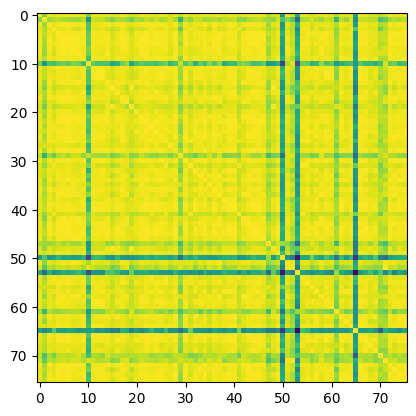

In [82]:
# add colors to plots
quantum_fidelity_matrix_np = quantum_fidelity_matrix.to_numpy(dtype=np.float64)
plt.imshow(quantum_fidelity_matrix_np)

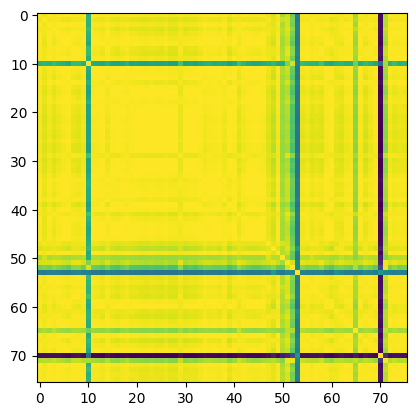

In [83]:
euclidean_distance_matrix_np = classical_distance_matrix.corr().to_numpy(dtype=np.float64)
plt.imshow(euclidean_distance_matrix_np)

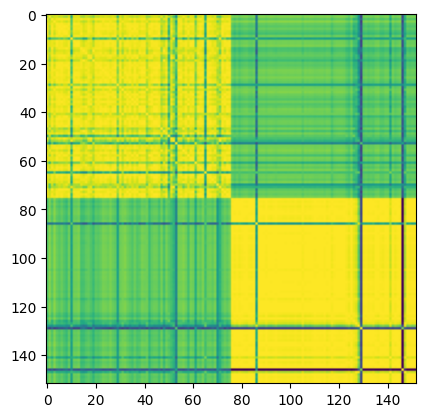

In [84]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
corr_of_corrs = np.corrcoef(quantum_fidelity_matrix_np, euclidean_distance_matrix_np)
plt.imshow(corr_of_corrs)

In [115]:
quantum_fidelity_matrix_np

array([[0.        , 0.98346862, 0.99830073, ..., 0.99747707, 0.99816466,
        0.99714238],
       [0.98346862, 0.        , 0.98634651, ..., 0.99026343, 0.98833832,
        0.99089476],
       [0.99830073, 0.98634651, 0.        , ..., 0.99746517, 0.99874415,
        0.99832167],
       ...,
       [0.99747707, 0.99026343, 0.99746517, ..., 0.        , 0.99787022,
        0.99848869],
       [0.99816466, 0.98833832, 0.99874415, ..., 0.99787022, 0.        ,
        0.99884717],
       [0.99714238, 0.99089476, 0.99832167, ..., 0.99848869, 0.99884717,
        0.        ]], shape=(76, 76))

In [91]:
# statistic = how correlated they are (from -1 to +1), pvalue = is it significant?
scipy.stats.kendalltau(quantum_fidelity_matrix_np, euclidean_distance_matrix_np)

SignificanceResult(statistic=np.float64(0.462532973412784), pvalue=np.float64(0.0))

In [162]:
# the proper test for 2 distance matrices is actually Mantel's test.
# we can use this if we have *distance* matrices to test if they are correlated
# https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
# says spearman should be use when non-linearity is expected
# as implemented in skbio, mantel's test requires the diagnoals to be 0
from skbio.stats.distance import mantel, pwmantel
np.fill_diagonal(quantum_fidelity_matrix_np, 0)
np.fill_diagonal(euclidean_distance_matrix_np, 0)
# corr_coeff, p, n_values
mantel(quantum_fidelity_matrix_np, euclidean_distance_matrix_np, seed=0)

(np.float64(-0.6095053887268291), np.float64(0.001), 76)

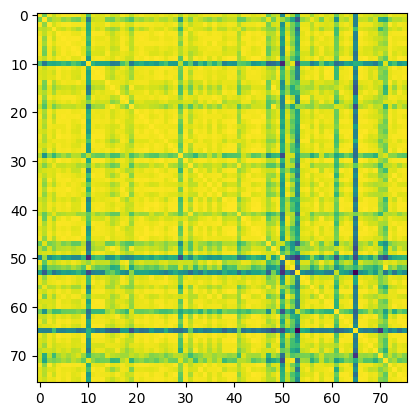

In [128]:
# take the correlation of the fidelity
plt.imshow(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64))

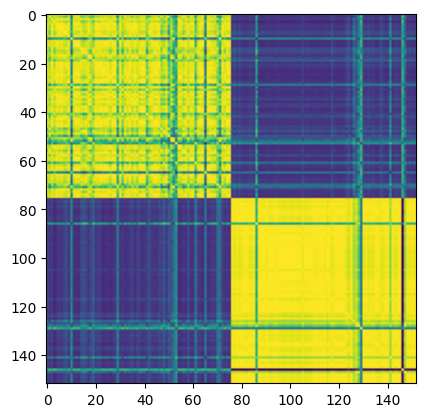

In [129]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
cross_corr_fidelitycorr_euclidean = np.corrcoef(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)
plt.imshow(cross_corr_fidelitycorr_euclidean)

In [92]:
# statistic = how correlated they are (from -1 to +1), pvalue = is it significant?
scipy.stats.kendalltau(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)

SignificanceResult(statistic=np.float64(0.468221322537112), pvalue=np.float64(0.0))

# Probability distribution analysis

Starting with just the mean first

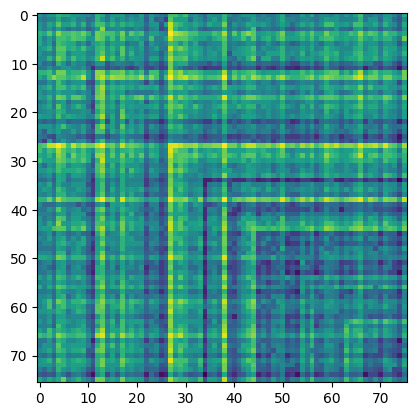

In [99]:
plt.imshow(quantum_mean_matrix.to_numpy(dtype=np.float64))

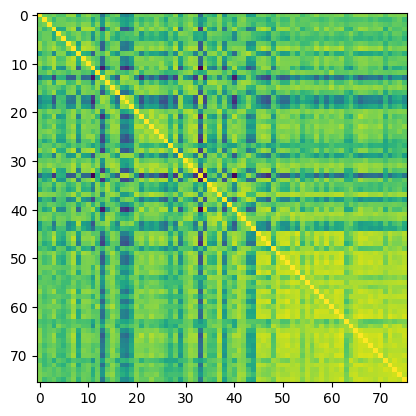

In [100]:
plt.imshow(quantum_mean_matrix.corr().to_numpy(dtype=np.float64))

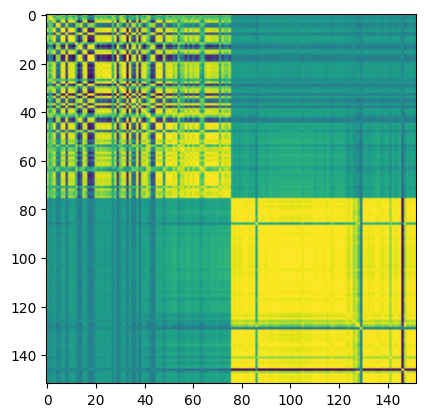

In [103]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
corr_of_corrs = np.corrcoef(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)
plt.imshow(corr_of_corrs)

In [105]:
# not very corrrelated
scipy.stats.kendalltau(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)

SignificanceResult(statistic=np.float64(0.04027470868492561), pvalue=np.float64(4.467243008588902e-06))

In [110]:
# not very corrrelated
scipy.stats.spearmanr(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np).statistic

array([[ 1.        ,  0.33334245,  0.51822283, ...,  0.0257553 ,
         0.01971292, -0.00792891],
       [ 0.33334245,  1.        ,  0.80891319, ..., -0.07926179,
        -0.04527683, -0.04757348],
       [ 0.51822283,  0.80891319,  1.        , ..., -0.0121121 ,
        -0.02293917, -0.02280246],
       ...,
       [ 0.0257553 , -0.07926179, -0.0121121 , ...,  1.        ,
         0.89312372,  0.91896104],
       [ 0.01971292, -0.04527683, -0.02293917, ...,  0.89312372,
         1.        ,  0.96642515],
       [-0.00792891, -0.04757348, -0.02280246, ...,  0.91896104,
         0.96642515,  1.        ]], shape=(152, 152))

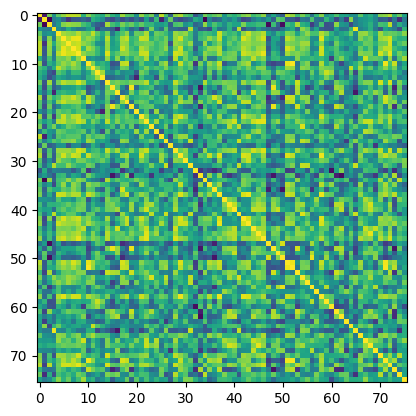

In [106]:
# compared to original data?
corrs = tuning_curves.T.corr().to_numpy()
plt.imshow(corrs)

SignificanceResult(statistic=np.float64(0.0284242949076979), pvalue=np.float64(0.0012024910453709218))

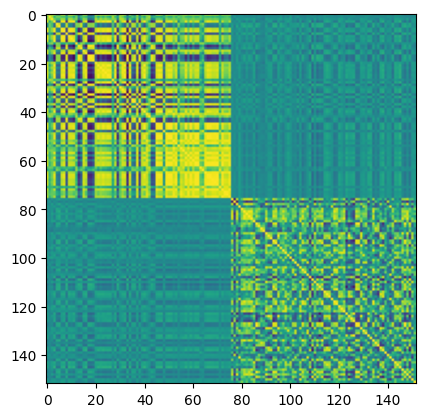

In [108]:
plt.imshow(np.corrcoef(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), corrs))
scipy.stats.kendalltau(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), corrs)

In [135]:
# the proper test for 2 distance matrices is actually Mantel's test
# https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
# says spearman should be use when non-linearity is expected
# as implemented in skbio, mantel's test requires the diagnoals to be 0
from skbio.stats.distance import mantel, pwmantel
np.fill_diagonal(quantum_mean_matrix.to_numpy(dtype=np.float64), 0)
np.fill_diagonal(euclidean_distance_matrix_np, 0)
# corr_coeff, p, n_values
mantel(quantum_mean_matrix, euclidean_distance_matrix_np, seed=0)

(np.float64(-0.17468373532125367), np.float64(0.107), 76)

In [137]:
pwmantel(dms = [quantum_mean_matrix, quantum_fidelity_matrix_np, euclidean_distance_matrix_np], labels=['mean probability', 'fidelity', 'euclidean distance'])

/home/user/work/quadrigems/.venv/lib/python3.11/site-packages/skbio/stats/distance/_mantel.py:397: NearConstantInputWarning: All values in data are nearly equal; results may not be reliable.
  warnings.warn(NearConstantInputWarning())


statistic  p-value   n   method  \
dm1              dm2                                                   
mean probability fidelity             0.052976    0.612  76  pearson   
                 euclidean distance  -0.174684    0.090  76  pearson   
fidelity         euclidean distance  -0.609505    0.001  76  pearson   

                                     permutations alternative  
dm1              dm2                                           
mean probability fidelity                     999   two-sided  
                 euclidean distance           999   two-sided  
fidelity         euclidean distance           999   two-sided

# weight histogram analysis

In [ ]:
_ = plt.hist(q_fidelity_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap')

In [ ]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

In [ ]:
_ = plt.hist(q_mean_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap (mean probability')

In [ ]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

similar distributions? with harmonic-ish stuff in research
- [superoscillations](https://www.semanticscholar.org/paper/Super-oscillation-by-higher-order-radially-beams-Matsunaga-Kozawa/0784f24ec848c9e2fa002c7806de992859977ee1)
- [higher-order gaussian](https://www.researchgate.net/figure/The-normalized-intensity-distribution-of-hollow-higher-order-cosh-Gaussian-beams-at-the_fig1_347963556)

# summary

- quantum state fidelity is highly correlated with euclidean distance
- using sigmoid may not help
- removing / adding Hs to the canonical swap produces uncorrelated value
- Taking the mean of the probability of the bitstrings can also produce an uncorrelated value
- kendalltau can show correlation

# TODO

- run on QPU (no mitigation)
- run on QPU (with Mitiq)
- end to end analysis